In [1]:
import pymc as pm
import pandas as pd
import numpy as np
import seaborn as sns, matplotlib.pyplot as plt
sns.set_theme()

In [2]:
data = pd.read_csv("datasets/Rethinking_Data/kline2.csv")

Text(0.5, 1.0, 'Tools vs. Log(Population)')

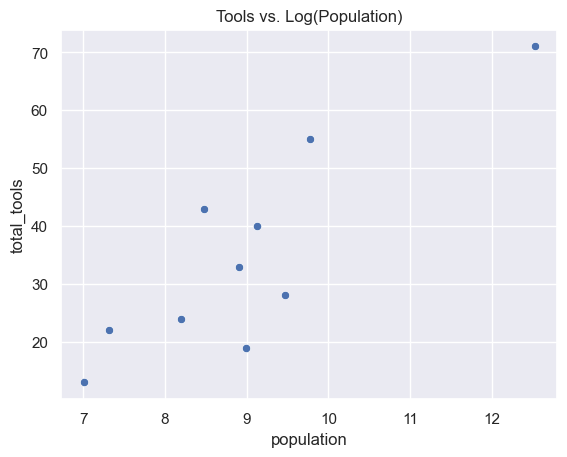

In [3]:
sns.scatterplot(x=np.log(data["population"]), y=data["total_tools"])
plt.title("Tools vs. Log(Population)")

In [4]:
y = data["total_tools"].to_numpy()
log_pop = np.log(data["population"].to_numpy())

## Simple Linear Regression

$$ \beta_i \sim N(0, 10) $$
$$ \tau \sim Exp(1) $$
$$ \mu = \beta_0 + \beta_1 X_i $$
$$ y_i | \mu, \sigma \sim N(\mu, 1 / \tau^2) $$

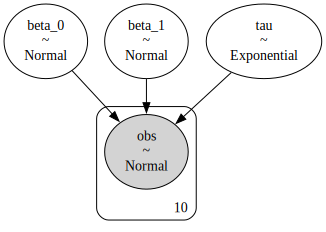

In [5]:
with pm.Model() as m1:
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)

    tau = pm.Exponential("tau", 1)
    mu = beta_0 + beta_1 * log_pop

    obs = pm.Normal("obs", mu=mu, sigma=1/tau, observed=y)
    
    prior = pm.sample_prior_predictive(samples=50)

pm.model_to_graphviz(m1)
    

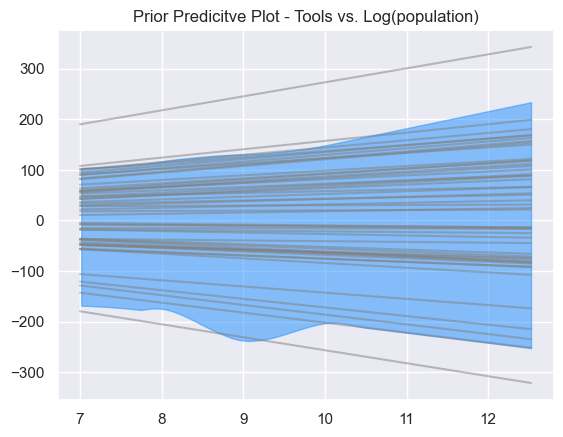

In [6]:
def plot_prior(prior):
    b1 = prior["prior"]["beta_1"].squeeze()
    b0 = prior["prior"]["beta_0"].squeeze()

    ys = np.matmul(log_pop.reshape(-1,1) , prior["prior"]["beta_1"].to_numpy()) + prior["prior"]["beta_0"].to_numpy()
    pm.plot_hdi(x=log_pop, y=prior["prior_predictive"]["obs"], color="dodgerblue")
    for i in range(ys.shape[1]):
        plt.plot(log_pop, ys[:,i], color="grey", alpha=0.5)
    plt.title("Prior Predicitve Plot - Tools vs. Log(population)")

plot_prior(prior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot: title={'center': 'beta_0'}>,
        <AxesSubplot: title={'center': 'beta_0'}>],
       [<AxesSubplot: title={'center': 'beta_1'}>,
        <AxesSubplot: title={'center': 'beta_1'}>],
       [<AxesSubplot: title={'center': 'tau'}>,
        <AxesSubplot: title={'center': 'tau'}>]], dtype=object)

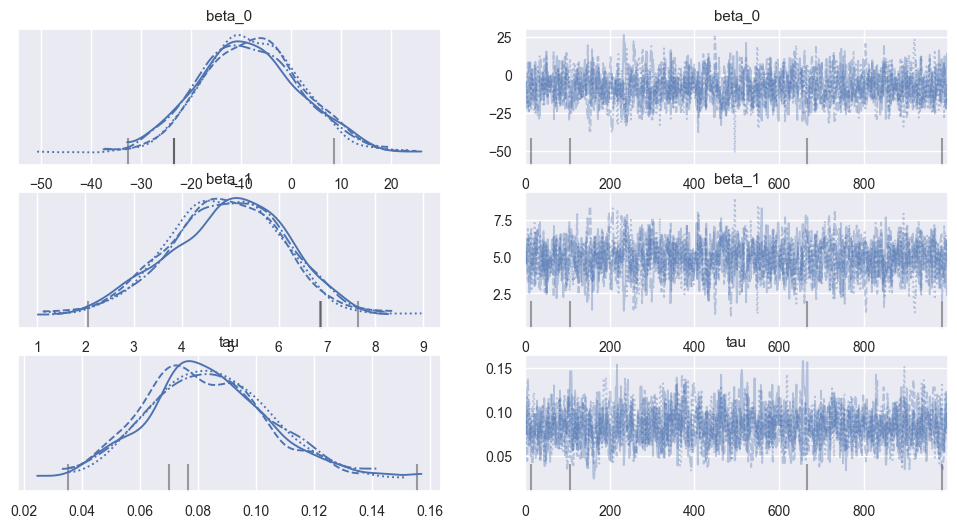

In [7]:
with m1:
    trace_m1 = pm.sample()
    post_m1 = pm.sample_posterior_predictive(trace_m1)

pm.plot_trace(trace_m1)

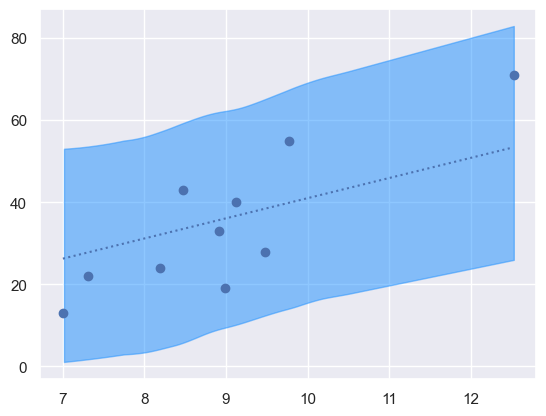

In [8]:
def plot_posterior(post, trace):
    b0 = trace["posterior"]["beta_0"].mean().to_numpy()
    b1 = trace["posterior"]["beta_1"].mean().to_numpy()

    x_ = np.arange(np.min(log_pop),np.max(log_pop),.1)
    y_ = b0 + b1*x_

    pm.plot_hdi(x=log_pop, y=post["posterior_predictive"]["obs"], color="dodgerblue")
    plt.plot(x_, y_, linestyle="dotted")
    plt.scatter(x=log_pop, y=y)

plot_posterior(post_m1, trace_m1)

## A simple model - modeling all with a constant Poisson parameter

$$ \beta \sim N(0, 5) $$
$$ \lambda = e^{\beta} $$
$$ y_i | \lambda \sim Poisson(\lambda) $$

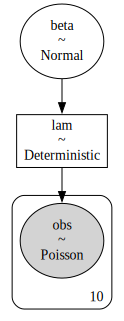

In [9]:
with pm.Model() as m2:
    beta = pm.Normal("beta", mu=0, sigma=5)
    lam = pm.Deterministic("lam", pm.math.exp(beta))

    obs = pm.Poisson("obs", mu=lam, observed=y)
    
    prior = pm.sample_prior_predictive(samples=20)

pm.model_to_graphviz(m2)
    

(20,)


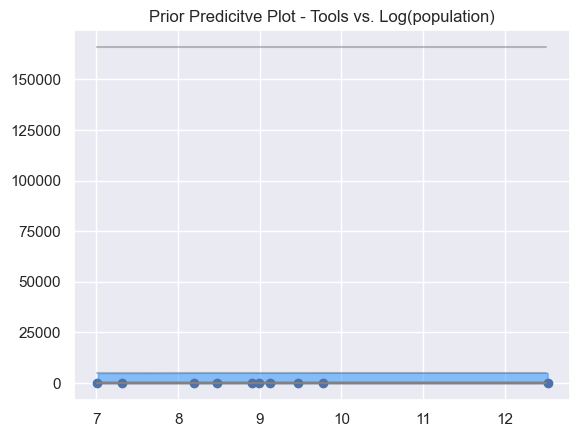

In [10]:
def plot_prior(prior):
    b1 = prior["prior"]["lam"].to_numpy().squeeze()
    print(b1.shape)

    pm.plot_hdi(x=log_pop, y=prior["prior_predictive"]["obs"], color="dodgerblue")
    plt.scatter(x=log_pop, y=y)
    plt.title("Prior Predicitve Plot - Tools vs. Log(population)")

    x_ = np.arange(np.min(log_pop), np.max(log_pop), 0.1)
    for i in range(b1.shape[0]):
        y_ = b1[i] * np.ones(len(x_))
        plt.plot(x_, y_, color="grey", alpha=0.5)

plot_prior(prior)

In [11]:
with m2:
    trace_m2 = pm.sample()
    post_m2 = pm.sample_posterior_predictive(trace_m2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


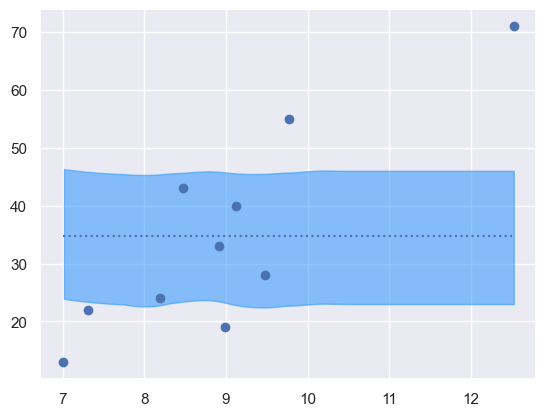

In [12]:
def plot_posterior(post, trace):
    beta = trace["posterior"]["beta"].mean().to_numpy()

    x_ = np.arange(np.min(log_pop),np.max(log_pop),.1)
    y_ = np.exp(beta) * np.ones(len(x_))
    
    pm.plot_hdi(x=log_pop, y=post["posterior_predictive"]["obs"], color="dodgerblue")
    plt.plot(x_, y_, linestyle="dotted")
    plt.scatter(x=log_pop, y=y)

plot_posterior(post_m2, trace_m2)


## A Poisson Regression

$$ \alpha_i \sim N(0,1) , \beta_i \sim N(0, 5) $$
$$ \lambda = e^{\beta_0 + \beta_1 X} $$
$$ y_i | \lambda \sim Poisson(\lambda) $$

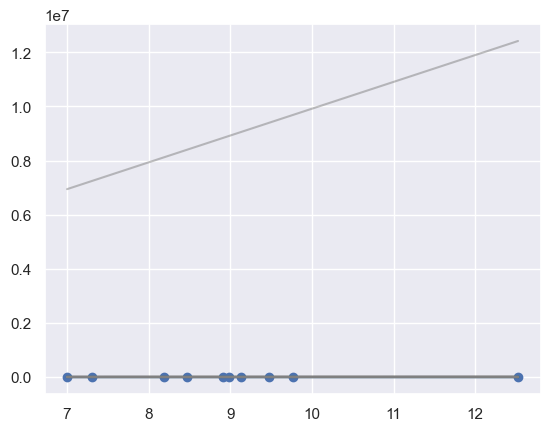

In [13]:
with pm.Model() as m3:
    alpha = pm.LogNormal("alpha", mu=0, sigma=1)
    beta = pm.LogNormal("beta", mu=0, sigma=5)

    lam = alpha + beta*log_pop

    obs = pm.Poisson("obs", mu=lam, observed=y)
    
    prior = pm.sample_prior_predictive(samples=20)

pm.model_to_graphviz(m3)
    
def plot_prior(prior):
    a_ = prior["prior"]["alpha"].to_numpy().squeeze()
    b_ = prior["prior"]["beta"].to_numpy().squeeze()

    x_ = np.arange(np.min(log_pop), np.max(log_pop), 0.1)
    pm.plot_hdi(x=log_pop, y=prior["prior_predictive"]["obs"], color="dodgerblue")
    plt.scatter(log_pop, y)
    for i in range(a_.shape[0]):
        ys = a_[i] + b_[i] * log_pop
        plt.plot(log_pop, ys, color="grey", alpha=0.5)

plot_prior(prior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot: title={'center': 'alpha'}>,
        <AxesSubplot: title={'center': 'alpha'}>],
       [<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>]], dtype=object)

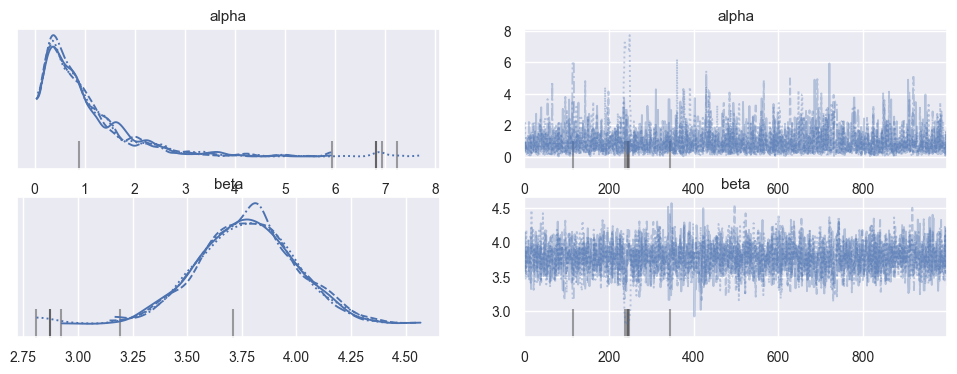

In [14]:
with m3:
    trace_m3 = pm.sample()
    post_m3 = pm.sample_posterior_predictive(trace_m3)
pm.plot_trace(trace_m3)

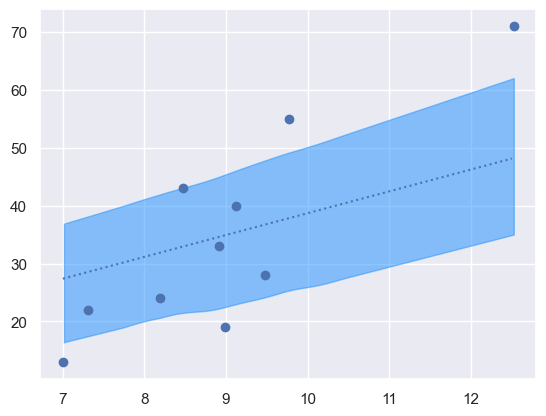

In [15]:
def plot_posterior(post, trace):
    a = trace["posterior"]["alpha"].mean().to_numpy()
    b = trace["posterior"]["beta"].mean().to_numpy()

    x_ = np.arange(np.min(log_pop),np.max(log_pop),.1)
    y_ = a + b*x_

    pm.plot_hdi(x=log_pop, y=post["posterior_predictive"]["obs"], color="dodgerblue")
    plt.plot(x_, y_, linestyle="dotted")
    plt.scatter(x=log_pop, y=y)
    
plot_posterior(post_m3, trace_m3)

## Richard McElreath (simplified)

$$ \delta T = \alpha P ^ \beta - \gamma T = 0 $$

Solving leads to 

$$ \hat{T} = \frac { \alpha P ^ \beta }{ \gamma } = \lambda $$

So we parameterize the model as

$$ \alpha \sim HalfNormal(0, 5) , \alpha > 0 $$
$$ \beta \sim N(0, 1), \gamma \sim Exp(1) $$
$$ \lambda = \frac { \alpha P ^ \beta}{ \gamma } $$

$$ log(\lambda) = log(\alpha) + \beta P - log(\gamma) $$

$$ y_i | \lambda \sim Poisson(\lambda) $$

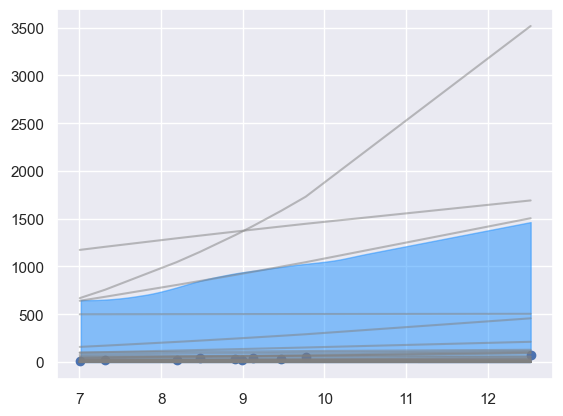

In [16]:
with pm.Model() as m4:
    alpha = pm.LogNormal("alpha", mu=1, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    gamma = pm.Exponential("gamma", 1)

    lam = alpha * (log_pop ** beta) / gamma
    
    obs = pm.Poisson("obs", mu=lam, observed=y)
    
    prior = pm.sample_prior_predictive(samples=50)

pm.model_to_graphviz(m4)
   
def plot_prior(prior):
    a_ = prior["prior"]["alpha"].to_numpy().squeeze()
    b_ = prior["prior"]["beta"].to_numpy().squeeze()
    g_ = prior["prior"]["gamma"].to_numpy().squeeze()

    x_ = np.arange(np.min(log_pop), np.max(log_pop), 0.1)
    pm.plot_hdi(x=log_pop, y=prior["prior_predictive"]["obs"], color="dodgerblue")
    plt.scatter(log_pop, y)
    for i in range(a_.shape[0]):
        ys = a_[i] * (log_pop ** b_[i]) / g_[i]
        plt.plot(log_pop, ys, color="grey", alpha=0.5)

plot_prior(prior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 28 seconds.


array([[<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>],
       [<AxesSubplot: title={'center': 'alpha'}>,
        <AxesSubplot: title={'center': 'alpha'}>],
       [<AxesSubplot: title={'center': 'gamma'}>,
        <AxesSubplot: title={'center': 'gamma'}>]], dtype=object)

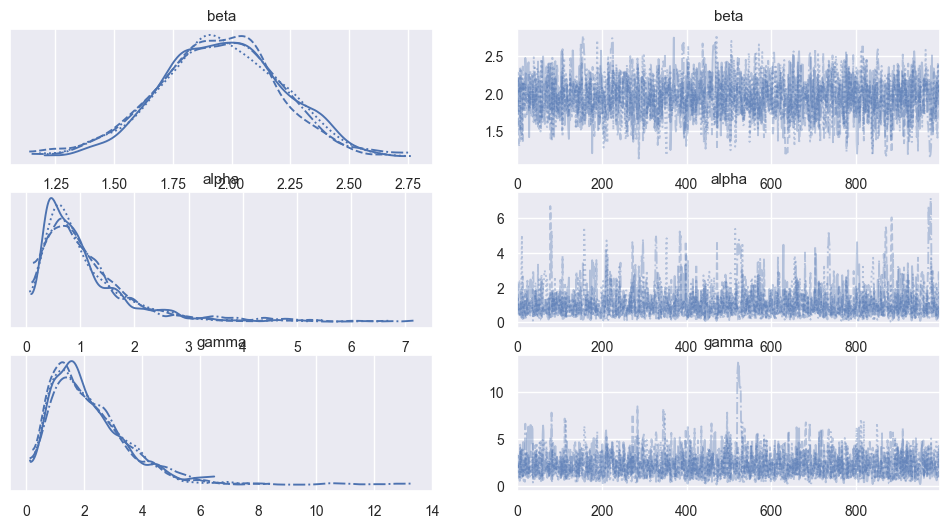

In [17]:
with m4:
    trace_m4 = pm.sample(tune=2000)
    post_m4 = pm.sample_posterior_predictive(trace_m4)
pm.plot_trace(trace_m4)

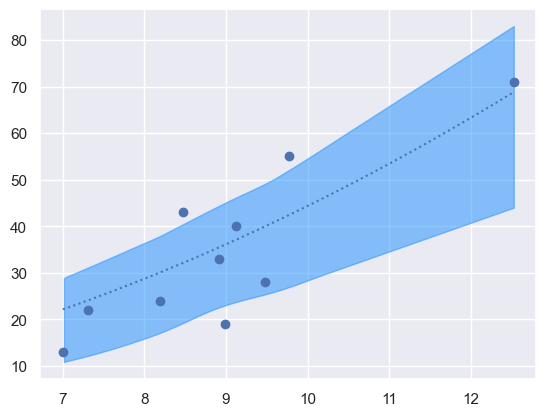

In [18]:
def plot_posterior(post, trace):
    a = trace["posterior"]["alpha"].mean().to_numpy()
    b = trace["posterior"]["beta"].mean().to_numpy()
    g = trace["posterior"]["gamma"].mean().to_numpy()

    x_ = np.arange(np.min(log_pop),np.max(log_pop),.1)
    y_ = a * x_ ** b / g

    pm.plot_hdi(x=log_pop, y=post["posterior_predictive"]["obs"], color="dodgerblue")
    plt.plot(x_, y_, linestyle="dotted")
    plt.scatter(x=log_pop, y=y)
    
plot_posterior(post_m4, trace_m4)